# Training a CNN on MNIST

By Richard Yue


In [1]:
%load_ext tensorboard

In [2]:
!export CUDA_VISIBLE_DEVICES=0

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime

2025-02-03 23:36:10.992125: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738643771.013955 1097221 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738643771.020441 1097221 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-03 23:36:11.041773: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
print(tf.config.list_physical_devices())

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
!rm -rf ./logs/

### MNIST with a ConvNet

Here we demonstrate a ConvNet to solve the MNIST problem

In [6]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

I0000 00:00:1738643813.053403 1097221 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:83:00.0, compute capability: 6.0


In [7]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(64)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

In [8]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(64)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

In [9]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.MaxPooling2D((2, 2)),
  tf.keras.layers.Dropout(rate=0.1),
  tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
  tf.keras.layers.LayerNormalization(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(32, activation='relu'),
  tf.keras.layers.Dense(16, activation='relu'),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.00003),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# this is for tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

/home/yue.r/miniconda3/envs/dl/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
%%time
#model training
history = model.fit(
    ds_train,
    epochs=40,
    validation_data=ds_test,
    callbacks=[tensorboard_callback]
  )

Epoch 1/40


2025-02-03 23:37:29.728570: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:376] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
I0000 00:00:1738643851.720960 1097622 service.cc:148] XLA service 0xb50bb50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738643851.720994 1097622 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-12GB, Compute Capability 6.0
2025-02-03 23:37:31.788075: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1738643852.159500 1097622 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-03 23:37:32.642689: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,13,13]{3,2,1,0}, f32[64,32,3,3]{

928/938 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.7186 - sparse_categorical_accuracy: 0.3981

2025-02-03 23:37:40.268535: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-03 23:37:40.313470: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[32,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,5,5]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7135 - sparse_categorical_accuracy: 0.4003

2025-02-03 23:37:42.923605: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,64,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,13,13]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]}
2025-02-03 23:37:42.972492: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:557] Omitted potentially buggy algorithm eng14{} for conv (f32[64,64,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,64,5,5]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"cudnn_conv

938/938 ━━━━━━━━━━━━━━━━━━━━ 17s 9ms/step - loss: 1.7130 - sparse_categorical_accuracy: 0.4005 - val_loss: 0.5446 - val_sparse_categorical_accuracy: 0.8721
Epoch 2/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.4914 - sparse_categorical_accuracy: 0.8920 - val_loss: 0.2158 - val_sparse_categorical_accuracy: 0.9489
Epoch 3/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.2328 - sparse_categorical_accuracy: 0.9451 - val_loss: 0.1347 - val_sparse_categorical_accuracy: 0.9655
Epoch 4/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1533 - sparse_categorical_accuracy: 0.9601 - val_loss: 0.1011 - val_sparse_categorical_accuracy: 0.9722
Epoch 5/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.1143 - sparse_categorical_accuracy: 0.9695 - val_loss: 0.0799 - val_sparse_categorical_accuracy: 0.9777
Epoch 6/40
938/938 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0913 - sparse_categorical_accuracy: 0.9757 - val_loss: 0.0682 - val_sparse_categorical_accuracy: 0.9813
Epoch 7/40
938

In [11]:
import matplotlib.pyplot as plt
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

def plot_acc(history):
  plt.plot(history.history['sparse_categorical_accuracy'], label='accuracy')
  plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_accuracy')
  plt.ylim([0, 1])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

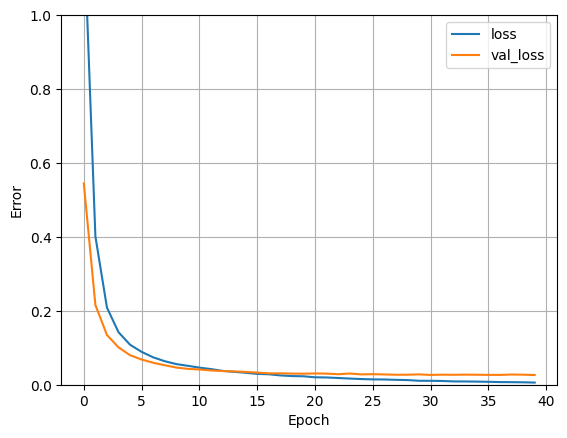

In [12]:
plot_loss(history)

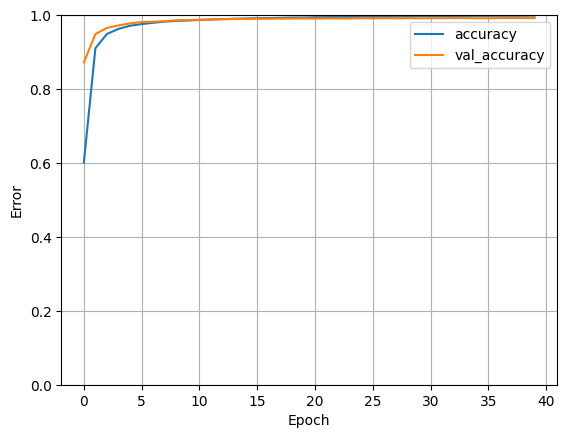

In [13]:
plot_acc(history)

In [14]:
model.evaluate(ds_test, batch_size=128)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0237 - sparse_categorical_accuracy: 0.9927


[0.0262756310403347, 0.9921000003814697]

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


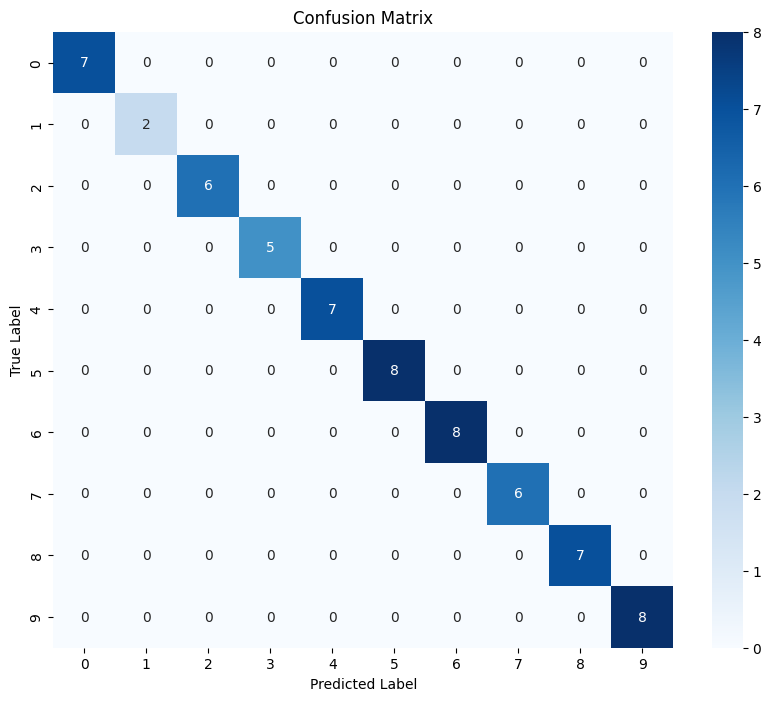

In [19]:
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns

test_images, test_labels = next(iter(ds_test.take(1)))
predicted_probabilities = model.predict(test_images)
predicted_labels = np.argmax(predicted_probabilities, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()